<h1><font color= "yellow">Extraction et Exploration de l’Espace
Latent d’un Autoencodeur
PCA, t-SNE et UMAP

In [1]:
!pip install --upgrade --force-reinstall \
    umap-learn==0.5.3 \
    scikit-learn==1.2.2 \
    numpy==1.26.4 \
    scipy==1.15.3 \
    numba==0.60.0 \
    llvmlite==0.43.0 \
    openTSNE

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.2/88.2 kB 5.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.3/7.3 MB 69.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.7/57.7 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 119.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.3/37.3 MB 27.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 69.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.9/43.9 MB 18.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.5/3.5 MB 97.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

#  Introduction Générale : Visualisation de l'Espace Latent

Ce tutoriel porte sur une étape cruciale de l'apprentissage non supervisé : l'**analyse et la visualisation de l'espace latent**  généré par un Autoencodeur Convolutif.

### Le Principe : De 128 à 2 Dimensions

Après avoir entraîné l'Encodeur à compresser les images en un vecteur de **128 dimensions** (suite au Global Average Pooling), l'œil humain ne peut pas visualiser cet espace.

Nous utilisons donc des techniques de **réduction de dimensionnalité** (comme PCA, t-SNE, et UMAP) pour projeter ces 128 dimensions sur seulement **2 dimensions** (un plan 2D).

### L'Intérêt de la Visualisation

La visualisation des données projetées en 2D nous permet de répondre à la question suivante :

> **Les images similaires sont-elles regroupées dans l'espace latent, et les images différentes sont-elles séparées ?**

* Si les points représentant les mêmes chiffres forment un **cluster compact** et sont éloignés des autres clusters, cela signifie que l'autoencodeur a réussi à extraire des **caractéristiques pertinentes** et à organiser logiquement les données.


## Partie 1 :  l'Architecture du Modèle

 **Autoencodeur Convolutif** est un modèle d'apprentissage profond non supervisé, essentiel pour l'apprentissage de représentations et la réduction de dimensionnalité. L'architecture est symétriquement divisée en l'**Encodeur** et le **Décodeur**, connectés par un **goulot d'étranglement**.

### 1. L'Encodeur

L'Encodeur mappe l'image d'entrée  de haute dimension vers une représentation latente de basse dimension en utilisant des couches $\text{Conv2D}$ et $\text{MaxPooling}$.

$$
\begin{array}{|c|c|c|c|}
    \hline
    \text{Couche} & \text{Taille d'Entrée} & \text{Opération} & \text{Taille de Sortie} \\
    \hline
    \text{  1} & (32, 32, 1) & \text{Conv2D}(32,(3,3),padding='same', relu) + \text{MaxPooling}(2) & (16, 16, 32) \\
    \hline
    \text{  2} & (16, 16, 32) & \text{Conv2D}(64,(3,3),padding='same', relu) + \text{MaxPooling}(2) & (8, 8, 64) \\
    \hline
    \text{  3} & (8, 8, 64) & \text{Conv2D}(128,(3,3), padding='same', relu) + \text{MaxPooling}(2) & \mathbf{(4, 4, 128)} \\
    \hline
\end{array}
$$

### 2. Le Décodeur   

Le Décodeur prend le code latent et le décompresse pour **reconstruire l'image originale** en utilisant des couches $\mathbf{\text{Conv2D}}$ et $\mathbf{\text{UpSampling2D}}$.

$$
\begin{array}{|c|c|c|c|}
    \hline
    \text{Couche} & \text{Taille d'Entrée} & \text{Opération} & \text{Taille de Sortie} \\
    \hline
    \text{ 1} & (4, 4, 128) & \text{Conv2D}(128, (3,3),padding='same', relu) + \text{UpSampling}(2) & (8, 8, 128) \\
    \hline
    \text{  2} & (8, 8, 128) & \text{Conv2D}(64,(3,3),padding='same', relu) + \text{UpSampling}(2) & (16, 16, 64) \\
    \hline
    \text{  3} & (16, 16, 64) & \text{Conv2D}(32,(3,3),padding='same', relu) + \text{UpSampling}(2) & (32, 32, 32) \\
    \hline
    \text{Sortie} & (32, 32, 32) & \text{Conv2D}(1 \text{ filtre},(3,3),padding='same',  \text{sigmoid}) & \mathbf{(32, 32, 1)} \\
    \hline
\end{array}
$$




In [1]:
# Importations nécessaires
import numpy as np
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Conv2DTranspose
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import mnist
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import warnings
import os
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap
from openTSNE import TSNE

warnings.filterwarnings("ignore")
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

# Chargement de MNIST
(X_train, Y_train), (X_test, Y_test) = mnist.load_data()

# Normalisation et ajout de la dimension canal
X_train = X_train.astype('float32') / 255.
X_test = X_test.astype('float32') / 255.
X_train = np.expand_dims(X_train, axis=-1)
X_test = np.expand_dims(X_test, axis=-1)

# Padding des images à 32x32 pour éviter les problèmes de dimensions avec les poolings/upsamplings
X_train = np.pad(X_train, ((0,0), (2,2), (2,2), (0,0)), mode='constant', constant_values=0)
X_test = np.pad(X_test, ((0,0), (2,2), (2,2), (0,0)), mode='constant', constant_values=0)



11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


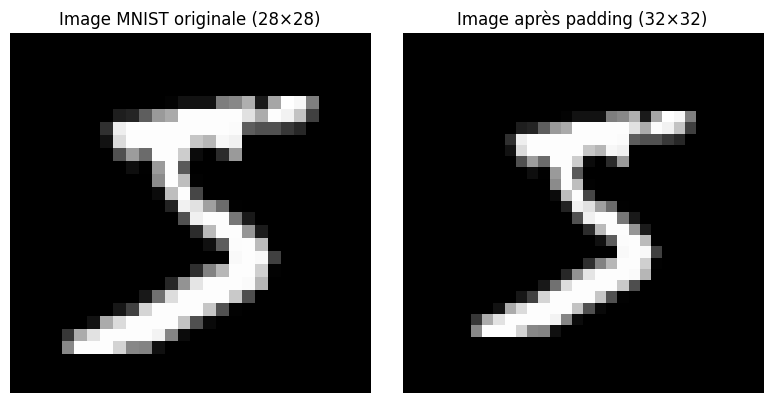

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<Figure size 640x480 with 0 Axes>

In [2]:
# --- Exemple d’image avant et après prétraitement ---

# Charger une image brute avant tout prétraitement
(X_raw, _), _ = mnist.load_data()
img_original = X_raw[0]   # 28x28

# Image normalisée
img_norm = img_original.astype('float32') / 255.
img_norm = np.expand_dims(img_norm, axis=-1)

# Application du padding 32x32
img_padded = np.pad(img_norm, pad_width=((2,2),(2,2),(0,0)), mode='constant', constant_values=0)

# Affichage côte à côte
plt.figure(figsize=(8,4))

# --- Image originale ---
plt.subplot(1, 2, 1)
plt.imshow(img_original, cmap='gray')
plt.title("Image MNIST originale (28×28)")
plt.axis("off")

# --- Image paddée ---
plt.subplot(1, 2, 2)
plt.imshow(img_padded[:,:,0], cmap='gray')
plt.title("Image après padding (32×32)")
plt.axis("off")
plt.tight_layout()
plt.savefig("padding.png")

plt.show()
from google.colab import files
files.download("padding.png")

Epoch 1/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 17s 39ms/step - loss: 0.2160 - val_loss: 0.0800
Epoch 2/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - loss: 0.0772 - val_loss: 0.0684
Epoch 3/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - loss: 0.0680 - val_loss: 0.0656
Epoch 4/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - loss: 0.0641 - val_loss: 0.0613
Epoch 5/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - loss: 0.0612 - val_loss: 0.0595
Epoch 6/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - loss: 0.0596 - val_loss: 0.0580
Epoch 7/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - loss: 0.0584 - val_loss: 0.0571
Epoch 8/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - loss: 0.0573 - val_loss: 0.0561
Epoch 9/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - loss: 0.0567 - val_loss: 0.0557
Epoch 10/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - loss: 0.0560 - val_loss: 0.0552
Epoch 11/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - loss: 0.0556 - val_loss: 0.0548
Epoch 12/50
235/235 ━━━━━━━━━━━━━━━━━━━━

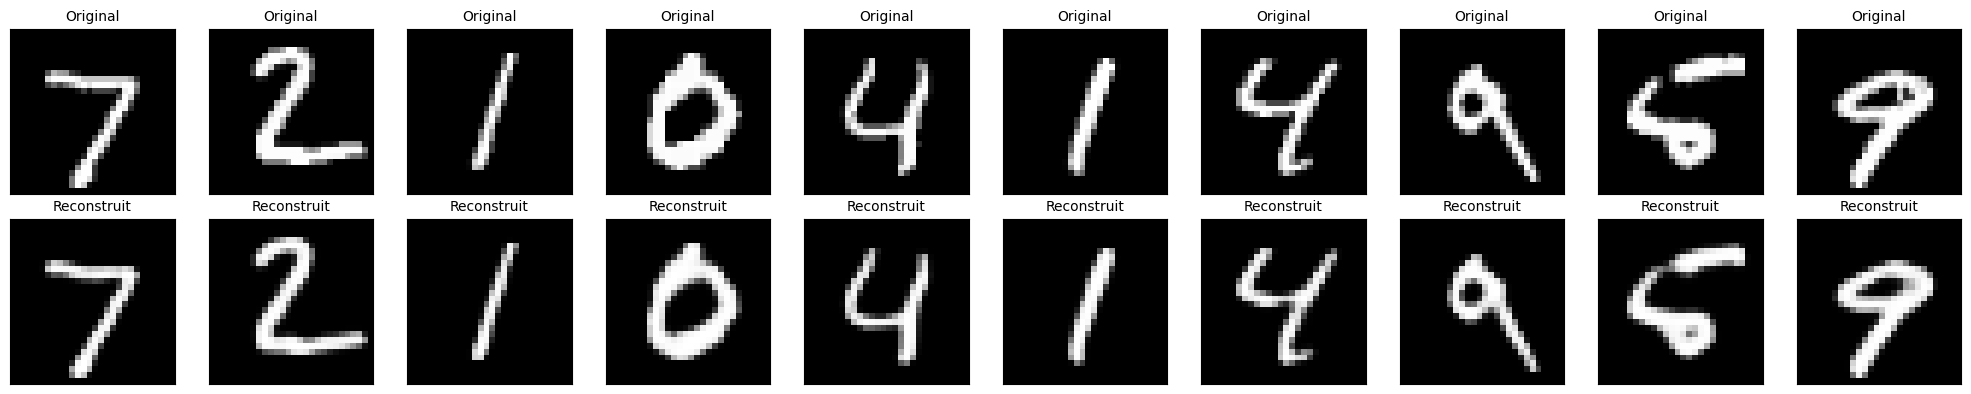

In [3]:
input_img = Input(shape=(32, 32, 1))

# -------------------
#      ENCODEUR
# -------------------
x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)

x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)

x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)

encoded = x   # forme : (4, 4, 128)

# -------------------
#      DECODEUR
# -------------------
x = Conv2D(128, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)

x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)

x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)

decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

# Entraînement
autoencoder.fit(X_train, X_train, epochs=50, batch_size=256, shuffle=True, validation_data=(X_test, X_test))

# Reconstruction et visualisation basique
decoded_imgs = autoencoder.predict(X_test)

n = 10
plt.figure(figsize=(20, 4))

for i in range(n):
    # --- Image originale ---
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(X_test[i, 2:30, 2:30, 0], cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.set_title("Original", fontsize=10)

    # --- Image reconstruite ---
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i, 2:30, 2:30, 0], cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.set_title("Reconstruit", fontsize=10)

plt.tight_layout()
plt.show()



# Partie 2 : Visualisation de l'Apprentissage des donneés d'entrainement

L'objectif principal de cette partie est de **visualiser la qualité de l'apprentissage** des donneés d'entrainement de l'encodeur.

1.  **Extraction de la Représentation :** Isoler l'Encodeur pour obtenir la représentation la plus compressée des données de l'entraînement, appelée **code latent**.
    $$
    \text{Shape du code latent }: \quad \mathbf{(60000, 4 \times 4, 128)}
    $$

2.  **Préparation pour la Réduction :** Appliquer le **Global Average Pooling** (moyenne sur les dimensions spatiales) pour réduire la dimension spatiale, transformant le code latent en un vecteur dense de **128 dimensions** par image alors :
    $$
    \text{Shape du code latent devient }: \quad \mathbf{(60000, 128)}
    $$

3.  **Visualisation de la Séparation :** Utiliser les algorithmes de réduction de dimensionnalité (**PCA, t-SNE, UMAP**) sur ce vecteur de 128 dimensions pour projeter les données sur un plan 2D.
    * Cette projection permet de déterminer si l'autoencodeur a réussi à **regrouper efficacement les images similaires** (les mêmes chiffres).
    * Elle vérifie également si les différents groupes  sont **séparés** dans l'espace latent.

In [4]:
# Création du modèle encoder
encoder = Model(input_img, encoded)

# Extraction de l'espace latent
latent = encoder.predict(X_train, verbose=1)

# Application de Global Average Pooling
latent_avg = latent.mean(axis=(1, 2))


1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step


 <h2> <font color="orange" >🔹Visualisation de l'espace latent avec PCA sur des données d'entrainement</font> </h2>

Appliquez une **analyse en composantes principales (PCA)** aux données d’entraînement afin de réduire leur dimension à **deux composantes principales**.


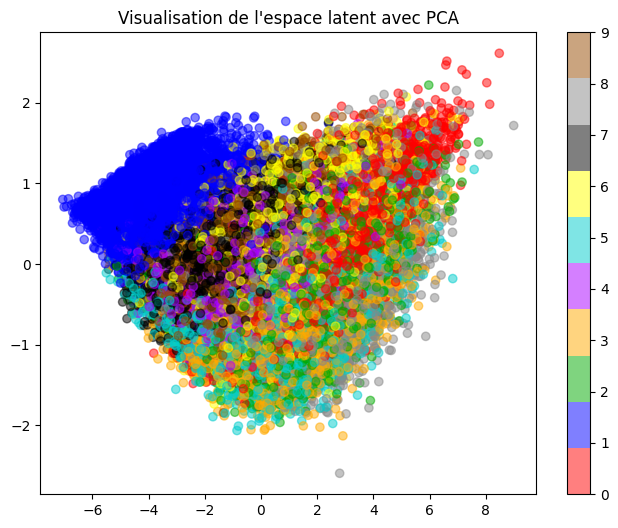

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [17]:
# PCA : réduction à 2 dimensions
pca = PCA(n_components=2)
pca_result = pca.fit_transform(latent_avg)

couleurs = [
    "#FF0000","#0000FF","#00AA00","#FFAA00", "#AA00FF",
    "#00CCCC","#FFFF00","#000000","#888888","#964B00"
]





cmap_perso = ListedColormap(couleurs)

# Visualisation
plt.figure(figsize=(8, 6))
plt.scatter(pca_result[:, 0], pca_result[:, 1], c=Y_train, cmap=cmap_perso, alpha=0.5)
plt.title("Visualisation de l'espace latent avec PCA")
plt.colorbar()
plt.draw()
plt.savefig("pca.png")
plt.show()
from google.colab import files
files.download("pca.png")


 <h2> <font color="orange" >🔹Visualisation de l'espace latent avec t_SNE sur des données d'entrainement</font> </h2>


Appliquez la méthode **t-SNE** (*t-Distributed Stochastic Neighbor Embedding*) aux données d’entraînement afin de projeter celles-ci dans un espace bidimensionnel pour la visualisation.

####  Paramètres à utiliser :
- `perplexity = 25`  
- `n_iter = 500`  
- `n_components = 2`




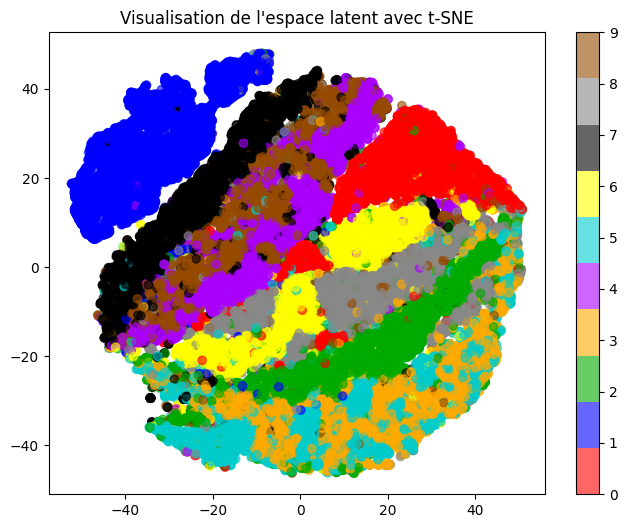

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [22]:
from sklearn.manifold import TSNE

# Application du t-SNE
tsne = TSNE(
    perplexity=25,
    n_iter=500,
    n_components=2,
    random_state=42
)

tsne_result = tsne.fit_transform(latent_avg)

couleurs = [
    "#FF0000","#0000FF","#00AA00","#FFAA00", "#AA00FF",
    "#00CCCC","#FFFF00","#000000","#888888","#964B00"
]

cmap_perso = ListedColormap(couleurs)

# Visualisation t-SNE
plt.figure(figsize=(8, 6))
plt.scatter(
    tsne_result[:, 0], tsne_result[:, 1],
    c=Y_train,
    cmap=cmap_perso,
    alpha=0.6
)
plt.title("Visualisation de l'espace latent avec t-SNE")
plt.colorbar()

# Sauvegarde
plt.draw()
plt.savefig("tsne.png", dpi=300)
plt.show()

# Téléchargement sous Colab
from google.colab import files
files.download("tsne.png")


 <h2> <font color="orange" >🔹Visualisation de l'espace latent avec UMAP sur des données d'entrainement</font> </h2>

Appliquez la méthode **UMAP (Uniform Manifold Approximation and Projection)** aux données d’entraînement afin de projeter celles-ci dans un **espace bidimensionnel** pour la visualisation.

**Paramètres à utiliser :**

- `n_neighbors = 15`
- `min_dist = 0.1`
- `n_epochs = 500`
- `n_components = 2`


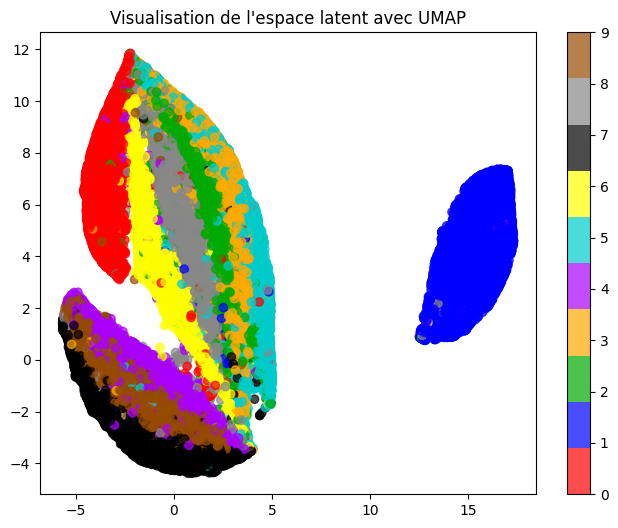

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [30]:
# Application de UMAP
umap_model = umap.UMAP(
    n_neighbors=15,
    min_dist=0.1,
    n_epochs=700,
    n_components=2,
    random_state=42
)


umap_result = umap_model.fit_transform(latent_avg)

# Couleurs
couleurs = [
    "#FF0000","#0000FF","#00AA00","#FFAA00", "#AA00FF",
    "#00CCCC","#FFFF00","#000000","#888888","#964B00"
]
cmap_perso = ListedColormap(couleurs)

# Visualisation UMAP
plt.figure(figsize=(8, 6))
plt.scatter(
    umap_result[:, 0], umap_result[:, 1],
    c=Y_train,
    cmap=cmap_perso,
    alpha=0.7
)
plt.title("Visualisation de l'espace latent avec UMAP")
plt.colorbar()
plt.draw()
plt.savefig("umap.png", dpi=300)
plt.show()
from google.colab import files
files.download("umap.png")


<h2> <font color="red" >Comparaison des 3 méthodes (Entrainement)</font> </h2>


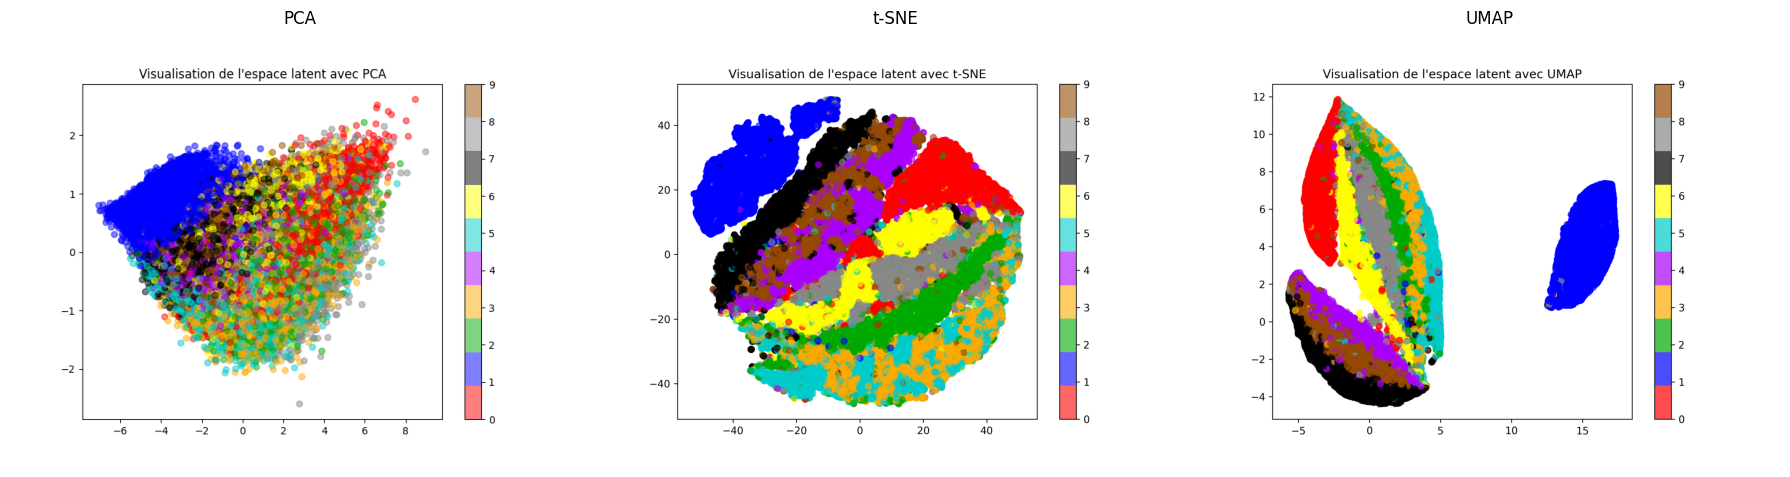

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [31]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Chargement des images
img_pca = mpimg.imread("pca.png")
img_tsne = mpimg.imread("tsne.png")
img_umap = mpimg.imread("umap.png")

# Création de la figure
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Image PCA
axes[0].imshow(img_pca)
axes[0].axis('off')
axes[0].set_title("PCA")

# Image t-SNE
axes[1].imshow(img_tsne)
axes[1].axis('off')
axes[1].set_title("t-SNE")

# Image UMAP
axes[2].imshow(img_umap)
axes[2].axis('off')
axes[2].set_title("UMAP")
plt.draw()
plt.savefig("entr.png")
plt.tight_layout()
plt.show()
from google.colab import files
files.download("entr.png")


<h2> <font color="pink" >Extraction du code latent (test)</font> </h2>







In [26]:
# Extraction du latent pour les données de test
latent_test = encoder.predict(X_test)

# Global Average Pooling
latent_test_avg = latent_test.mean(axis=(1, 2))


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


 <h2> <font color="blue" >🔹PCA sur les données de TEST</font> </h2>




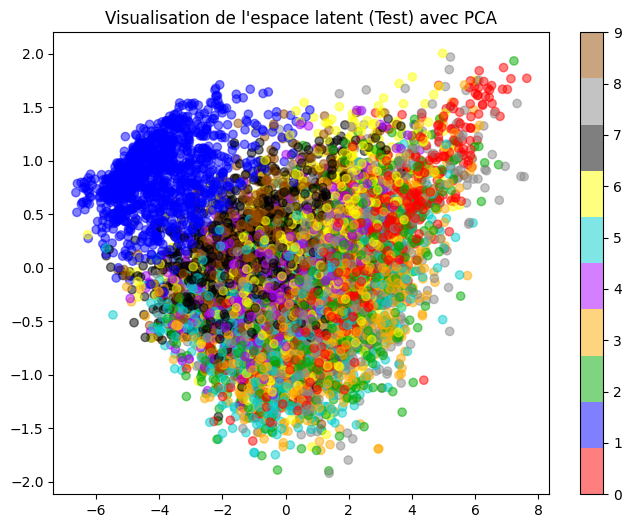

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [27]:
# Couleurs personnalisées
couleurs = [
    "#FF0000","#0000FF","#00AA00","#FFAA00", "#AA00FF",
    "#00CCCC","#FFFF00","#000000","#888888","#964B00"
]
cmap_perso = ListedColormap(couleurs)

# PCA sur l'espace latent des données test
pca = PCA(n_components=2)
pca_test_result = pca.fit_transform(latent_test_avg)

# Création explicite de la figure (pour éviter les images blanches)
fig = plt.figure(figsize=(8, 6))

plt.scatter(
    pca_test_result[:, 0],
    pca_test_result[:, 1],
    c=Y_test,
    cmap=cmap_perso,
    alpha=0.5
)

plt.title("Visualisation de l'espace latent (Test) avec PCA")
plt.colorbar()

# Sauvegarde explicite via l'objet figure
fig.savefig("pca_test.png", dpi=300)

plt.show()

# Téléchargement depuis Colab
from google.colab import files
files.download("pca_test.png")


 <h2> <font color="blue" >🔹t_SNE sur les données de TEST</font> </h2>




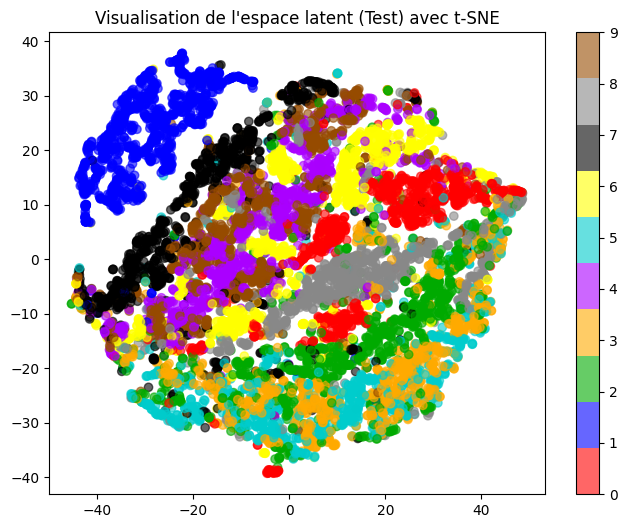

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [28]:
from sklearn.manifold import TSNE

# Application du t-SNE sur les données test
tsne_test = TSNE(
    n_components=2,
    perplexity=25,
    n_iter=500,
    random_state=42
)

tsne_test_result = tsne_test.fit_transform(latent_test_avg)

# Couleurs personnalisées
couleurs = [
    "#FF0000","#0000FF","#00AA00","#FFAA00", "#AA00FF",
    "#00CCCC","#FFFF00","#000000","#888888","#964B00"
]
cmap_perso = ListedColormap(couleurs)

# Création EXPlicite de la figure (évite images blanches)
fig = plt.figure(figsize=(8, 6))

plt.scatter(
    tsne_test_result[:, 0],
    tsne_test_result[:, 1],
    c=Y_test,
    cmap=cmap_perso,
    alpha=0.6
)

plt.title("Visualisation de l'espace latent (Test) avec t-SNE")
plt.colorbar()

# Sauvegarde fiable de la figure
fig.savefig("tsne_test.png", dpi=300)

plt.show()

# Téléchargement sous Colab
from google.colab import files
files.download("tsne_test.png")


 <h2> <font color="blue" >🔹UMAP sur les données de TEST</font> </h2>




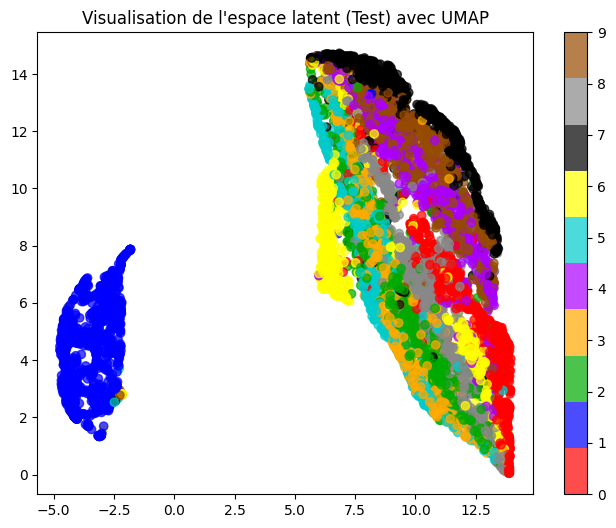

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [29]:
import umap

# Application de UMAP sur les données test
umap_test = umap.UMAP(
    n_neighbors=15,
    min_dist=0.1,
    n_components=2,
    n_epochs=600,
    random_state=42
)

umap_test_result = umap_test.fit_transform(latent_test_avg)

# Couleurs personnalisées
couleurs = [
    "#FF0000","#0000FF","#00AA00","#FFAA00", "#AA00FF",
    "#00CCCC","#FFFF00","#000000","#888888","#964B00"
]
cmap_perso = ListedColormap(couleurs)

# Création explicite de la figure (important pour éviter images blanches)
fig = plt.figure(figsize=(8, 6))

plt.scatter(
    umap_test_result[:, 0],
    umap_test_result[:, 1],
    c=Y_test,
    cmap=cmap_perso,
    alpha=0.7
)

plt.title("Visualisation de l'espace latent (Test) avec UMAP")
plt.colorbar()

# Sauvegarde propre
fig.savefig("umap_test.png", dpi=300)

plt.show()

# Téléchargement sous Colab
from google.colab import files
files.download("umap_test.png")


<h2> <font color="red" >Comparaison des 3 méthodes (Test)</font> </h2>


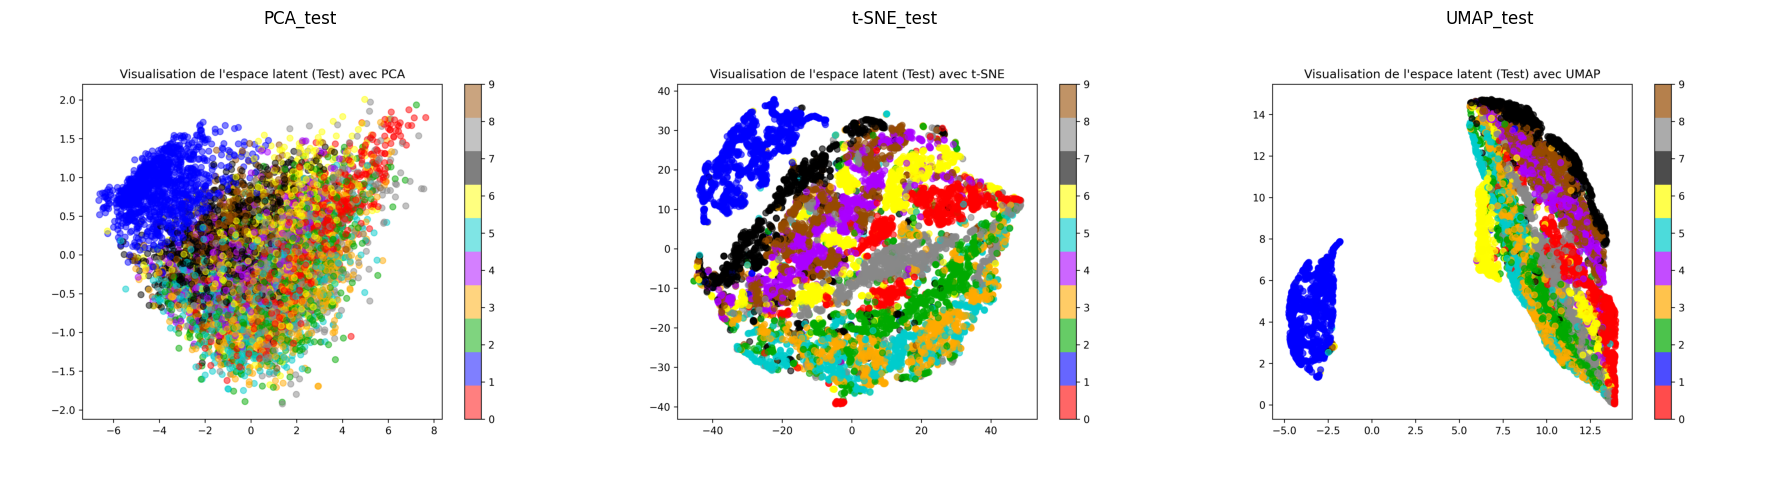

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [32]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Chargement des images
img_pca = mpimg.imread("pca_test.png")
img_tsne = mpimg.imread("tsne_test.png")
img_umap = mpimg.imread("umap_test.png")

# Création de la figure
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Image PCA
axes[0].imshow(img_pca)
axes[0].axis('off')
axes[0].set_title("PCA_test")

# Image t-SNE
axes[1].imshow(img_tsne)
axes[1].axis('off')
axes[1].set_title("t-SNE_test")

# Image UMAP
axes[2].imshow(img_umap)
axes[2].axis('off')
axes[2].set_title("UMAP_test")

plt.tight_layout()
plt.draw()
plt.savefig("test.png")
plt.show()
from google.colab import files
files.download("test.png")